In [1]:
from sklearn.manifold import TSNE
import numpy as np
import os
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Conv2D,MaxPooling2D
from keras.layers import Input, Embedding, Add
from keras import layers
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.models import load_model
from keras.utils import to_categorical
# NLTK
import nltk
from gensim.models import FastText
from gensim.models import Word2Vec
# Other
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import svm
from keras.layers.merge import concatenate
from keras.layers import Bidirectional
from keras.layers import K, Activation
from keras.engine import Layer
from keras.layers import Dense, Input, Embedding, Dropout, Bidirectional, GRU, Flatten, SpatialDropout1D
from keras.models import load_model
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import itertools

Using TensorFlow backend.


In [2]:
train = pd.read_excel('augmented.xlsx')
test = pd.read_excel('fbtest_cleaned.xlsx')

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])
sequences = tokenizer.texts_to_sequences(train['text'])
data = pad_sequences(sequences, maxlen=150)
print(data.shape)
sequences_t = tokenizer.texts_to_sequences(test['text'])
data_test = pad_sequences(sequences_t, maxlen=150)
print(data_test.shape)
vocabulary_size = len(tokenizer.word_index) + 1 # 20648

(39512, 150)
(916, 150)


In [4]:
gru_len = 128
Routings = 5
Num_capsule = 10
Dim_capsule = 16
dropout_p = 0.25
rate_drop_dense = 0.28

def squash(x, axis=-1):
    # s_squared_norm is really small
    # s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    # scale = K.sqrt(s_squared_norm)/ (0.5 + s_squared_norm)
    # return scale * x
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale


# A Capsule Implement with Pure Keras
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)




In [5]:
y_test = test['Agr_Class'].astype('category').cat.codes

In [6]:
codemixed_embeddings = FastText.load('augmented_ft.bin')
print(codemixed_embeddings )
embeddings_index = dict()
f = open('/home/parth/research/english/new_version/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

FastText(vocab=24411, size=100, alpha=0.025)
Loaded 400000 word vectors.


In [7]:
# create a weight matrix for words in training docs# create 
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_vector = codemixed_embeddings[word]
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [8]:
def define_model(length, vocabulary_size,embedding_matrix):
    input1 = Input(shape=(length,))
    embedding1 = Embedding(vocabulary_size,100, weights=[embedding_matrix], trainable=False)(input1)
    conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding1)
    conv1 = Dropout(0.5)(conv1)
    capsule1 = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=3,share_weights=True)(conv1)
    flat1 = Flatten()(capsule1)

    input2 = Input(shape=(length,))
    embedding2 = Embedding(vocabulary_size,100, weights=[embedding_matrix], trainable=False)(input2)
    conv2 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding2)
    conv2 = Dropout(0.5)(conv2)    
    capsule2 = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=3,share_weights=True)(conv2)
    flat2 = Flatten()(capsule2)    

    input3 = Input(shape=(length,))
    embedding3 = Embedding(vocabulary_size,100, weights=[embedding_matrix], trainable=False)(input3)
    conv3 = Conv1D(filters=32, kernel_size=5, activation='relu')(embedding3)   
    conv3 = Dropout(0.5)(conv3)    
    capsule3 = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=3,share_weights=True)(conv3)
    flat3 = Flatten()(capsule3)        

    merged = concatenate([flat1, flat2, flat3])
    
    dense = Dense(32,activation='relu')(merged)
    output = Dense(3, activation='softmax')(dense)
    model = Model(inputs=[input1,input2,input3], outputs=output)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [9]:
model = define_model(150, vocabulary_size,embedding_matrix)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 100)     2441200     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [24]:
model.load_weights('aug_caps_weights.h5')

(916, 2)
0 r CAG
1 g NAG
2 b OAG


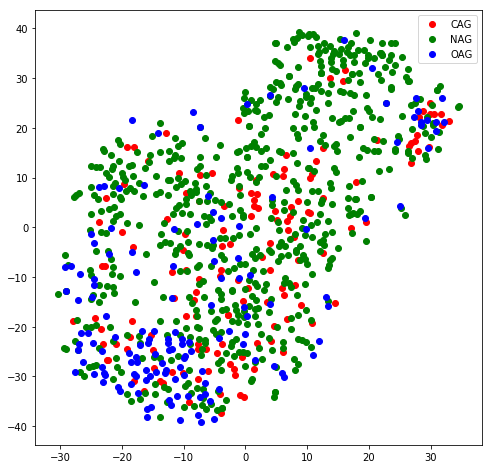

In [63]:
layer_name = 'flatten_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict([data_test,data_test,data_test])
X_embedded = TSNE(n_components=2).fit_transform(intermediate_output)
print(X_embedded.shape)
target_ids = range(3)
plt.figure(figsize=(8, 8))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, ['CAG','NAG','OAG']):
    print(i,c,label)
    plt.scatter(X_embedded[y_test == i, 0], X_embedded[y_test == i, 1], c=c, label=label)
plt.legend()
plt.show()

(916, 2)
0 r CAG
1 g NAG
2 b OAG


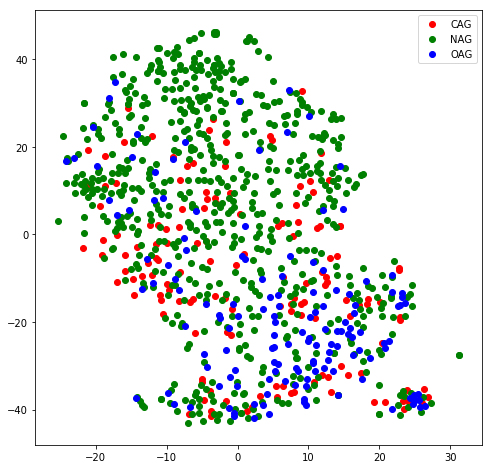

In [62]:
layer_name = 'flatten_2'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict([data_test,data_test,data_test])
X_embedded = TSNE(n_components=2).fit_transform(intermediate_output)
print(X_embedded.shape)
target_ids = range(3)
plt.figure(figsize=(8, 8))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, ['CAG','NAG','OAG']):
    print(i,c,label)
    plt.scatter(X_embedded[y_test == i, 0], X_embedded[y_test == i, 1], c=c, label=label)
plt.legend()
plt.show()

(916, 2)
0 r CAG
1 g NAG
2 b OAG


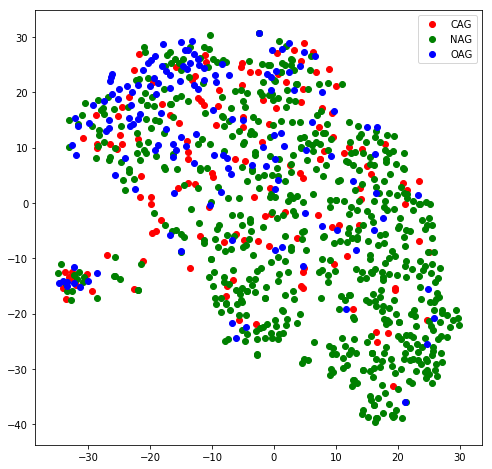

In [64]:
layer_name = 'flatten_3'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict([data_test,data_test,data_test])
X_embedded = TSNE(n_components=2).fit_transform(intermediate_output)
print(X_embedded.shape)
target_ids = range(3)
plt.figure(figsize=(8, 8))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, ['CAG','NAG','OAG']):
    print(i,c,label)
    plt.scatter(X_embedded[y_test == i, 0], X_embedded[y_test == i, 1], c=c, label=label)
plt.legend()
plt.show()

(916, 2)
0 r CAG
1 g NAG
2 b OAG


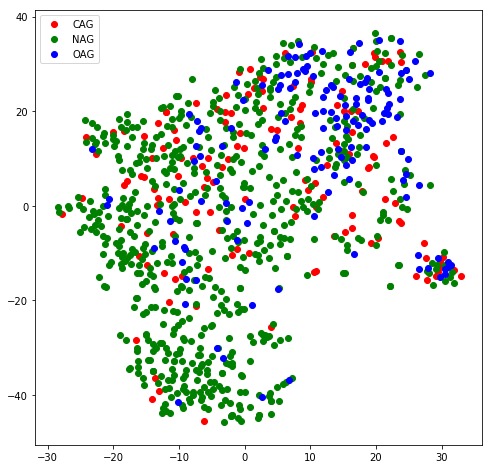

In [65]:
layer_name = 'concatenate_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict([data_test,data_test,data_test])
X_embedded = TSNE(n_components=2).fit_transform(intermediate_output)
print(X_embedded.shape)
target_ids = range(3)
plt.figure(figsize=(8, 8))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, ['CAG','NAG','OAG']):
    print(i,c,label)
    plt.scatter(X_embedded[y_test == i, 0], X_embedded[y_test == i, 1], c=c, label=label)
plt.legend()
plt.show()

(916, 2)
0 r CAG
1 g NAG
2 b OAG


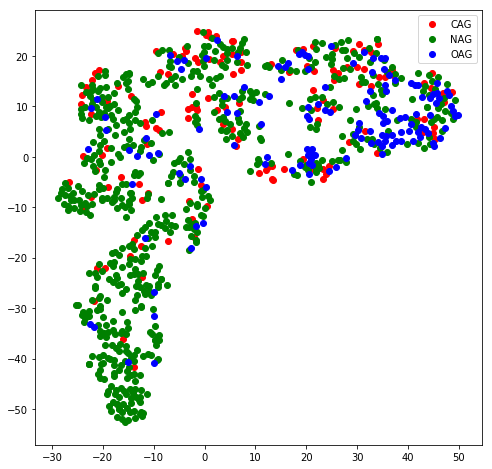

In [66]:
layer_name = 'dense_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict([data_test,data_test,data_test])
X_embedded = TSNE(n_components=2).fit_transform(intermediate_output)
print(X_embedded.shape)
target_ids = range(3)
plt.figure(figsize=(8, 8))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, ['CAG','NAG','OAG']):
    print(i,c,label)
    plt.scatter(X_embedded[y_test == i, 0], X_embedded[y_test == i, 1], c=c, label=label)
plt.legend()
plt.show()

(916, 2)
0 r CAG
1 g NAG
2 b OAG


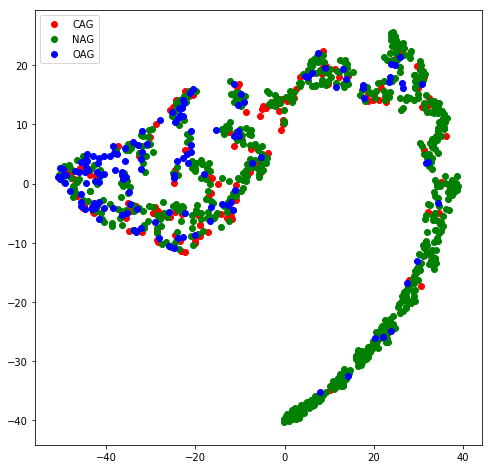

In [67]:
layer_name = 'dense_2'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict([data_test,data_test,data_test])
X_embedded = TSNE(n_components=2).fit_transform(intermediate_output)
print(X_embedded.shape)
target_ids = range(3)
plt.figure(figsize=(8, 8))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, ['CAG','NAG','OAG']):
    print(i,c,label)
    plt.scatter(X_embedded[y_test == i, 0], X_embedded[y_test == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [ ]:
stats significance, comparison
